
## Итоговый проект по курсу Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

Задача: предсказать стоимость недвижимости https://www.kaggle.com/c/real-estate-price-prediction-moscow/overview

Основные этапы:
1. Подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. Обучение модели
3. Проверка качества модели

Аккаунт на Kaggle https://www.kaggle.com/lknv1995 
User name lknv1995 
User ID 8438086

Импорт библиотек, настройка параметров, путь до данных

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
TRAIN_DATASET_PATH = './real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = './real-estate-price-prediction-moscow/test.csv'

Определение функций для обработки данных

In [5]:
def cor_type (df):
    """Корректные типы данных- перевод Id и DistrictId к строке"""
    df['Id'] = df['Id'].astype(str) 
    df['DistrictId'] = df['DistrictId'].astype(str) 
    return df
   

In [6]:
def cor_data (df):
    """Корректные данные - обработка выбросов и пропусков"""
     ### Комнаты
    df.loc[(df['Rooms'] == 0) & (df['Square'] < 41.7), 'Rooms'] = 1
    df.loc[(df['Rooms'] == 0) & (df['Square'] >= 41.7) & (df['Square'] < 65.9), 'Rooms'] = 2
    df.loc[(df['Rooms'] == 0) & (df['Square'] >= 65.9), 'Rooms'] = 4
    
    df.loc[(df['Rooms'] > 5) & (df['Square'] < 41.7), 'Rooms'] = 1
    df.loc[(df['Rooms'] > 5) & (df['Square'] >= 41.7) & (df['Square'] < 65.9), 'Rooms'] = 2
    df.loc[(df['Rooms'] > 5) & (df['Square'] >= 65.9), 'Rooms'] = 4
    
    ### Площадь
    df.loc[(df['Square'] < 14) & (df['Rooms'] == 1), 'Square'] = 41.322569
    df.loc[(df['Square'] > 200) & (df['Rooms'] == 5), 'Square'] = 122.614941
    df.loc[((df['Square'] < 14) | (df['Square'] > 200)) & 
         ((df['Rooms'] < 1) | (df['Rooms'] < 5)), 'Square'] = df['Square'].mean()  

    df['LifeS_nan'] = 0
    df.loc[df['LifeSquare'].isna(), 'LifeS_nan'] = 1
   
    df.loc[(df['LifeSquare'].isnull()) |
         (df['LifeSquare'] > df['Square']) |
         (df['LifeSquare'] < (df['Square'] * 0.5)), 'LifeSquare'] = df['Square'] * 0.75

    df['KitchenS_nan'] = 0
    df.loc[df['KitchenSquare'].isna(), 'KitchenS_nan'] = 1
    
    df.loc[(df['KitchenSquare'].isnull()) |
         (df['KitchenSquare'] > df['Square']) |
         (df['KitchenSquare'] < (df['Square'] * 0.1)) |
         (df['KitchenSquare'] > df['LifeSquare']), 'KitchenSquare'] = df['Square'] * 0.1

    df.loc[df['Square'] < (df['KitchenSquare'] + df['LifeSquare']),'LifeSquare'] = df['Square'] *0.75
    df.loc[df['Square'] < (df['KitchenSquare'] + df['LifeSquare']),'KitchenSquare'] = df['Square'] *0.1
    
    ### Год постройки
    df.loc[df['HouseYear'] < 1900, 'HouseYear'] = int(df['HouseYear'].median())
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    
    ### Этажность
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = int(df['HouseFloor'].median())
    df.loc[df['HouseFloor'] > 45, 'HouseFloor'] = df['Floor'] + 2
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df['Floor'] + 2
    
    ### Healthcare
    df['Healthcare_1_nan'] = 0
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
    
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
    
    return df

## Анализ и подготовка данных 

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


Анализ данных 

In [8]:
train_df.shape

(10000, 20)

In [9]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Целевая переменная

In [10]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

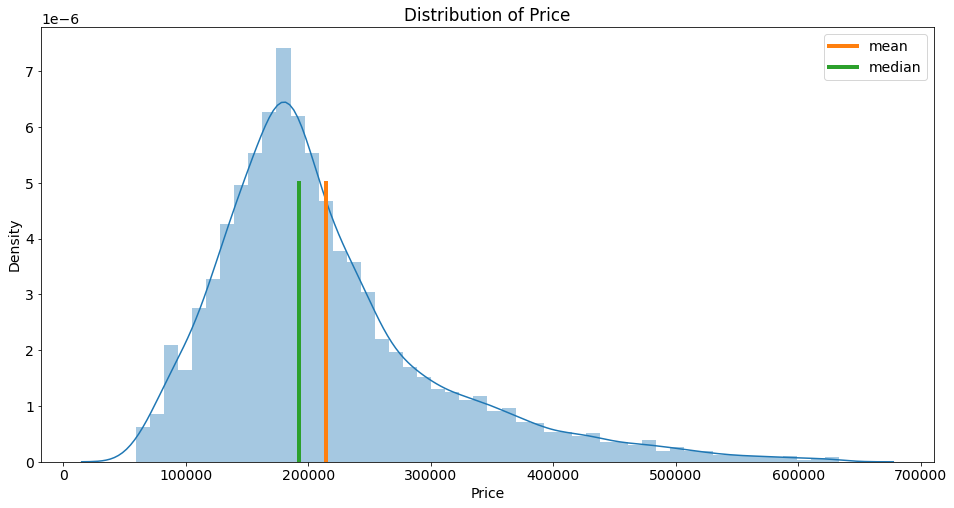

In [11]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Количественные признаки

In [12]:
df_num = train_df.select_dtypes(include=['int64','float64'])
df_num.drop('Id', axis=1, inplace=True)
df_num.drop('DistrictId', axis=1, inplace=True)
df_num.drop('Price', axis=1, inplace=True)

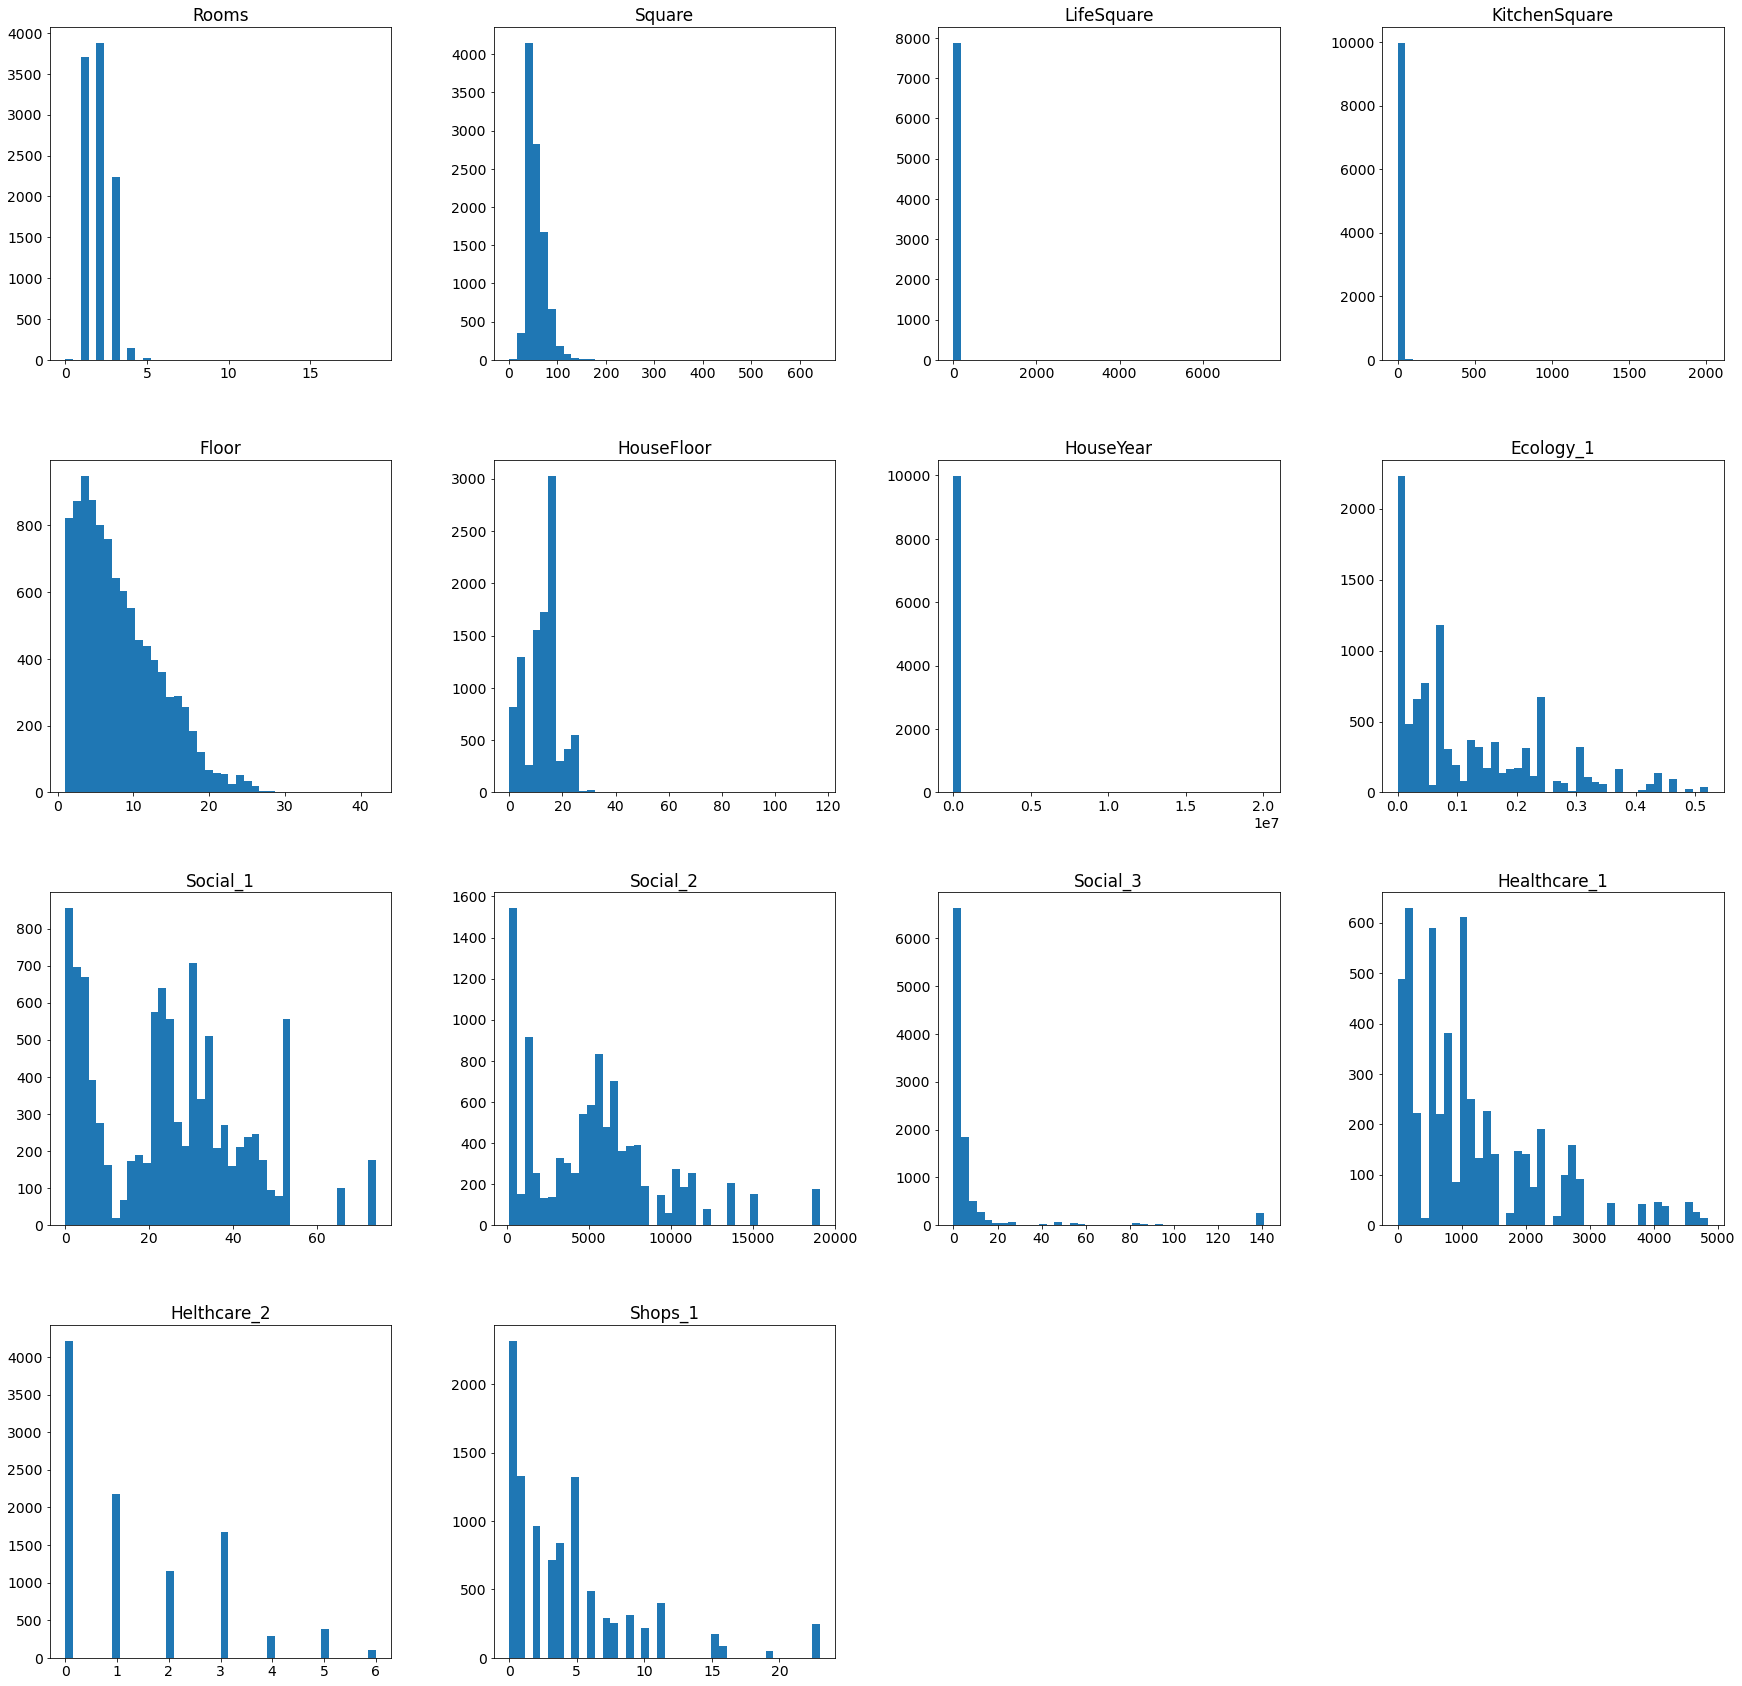

In [13]:
df_num.hist(figsize=(30,30), bins=40, grid=False);

<Figure size 288x288 with 0 Axes>

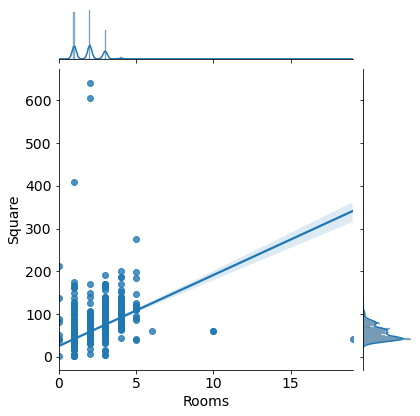

In [14]:
plt.figure(figsize = (4, 4))

grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
plt.show()

Категориальные признаки

In [15]:
train_df['Ecology_2'].describe()

count     10000
unique        2
top           B
freq       9903
Name: Ecology_2, dtype: object

In [16]:
train_df['Ecology_3'].describe()

count     10000
unique        2
top           B
freq       9725
Name: Ecology_3, dtype: object

In [17]:
train_df['Shops_2'].describe()

count     10000
unique        2
top           B
freq       9175
Name: Shops_2, dtype: object

Обработка данных, генерация новых признаков

In [18]:
cor_type(train_df)
cor_data(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeS_nan,KitchenS_nan,Healthcare_1_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,11809,27,3.0,115.027311,86.270483,11.502731,4,10.0,2014,0.075424,...,0,0,B,305018.871089,1,0,1,1,1,1
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,1,1,1
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,1,1,1
3,2352,1,1.0,40.409907,30.307430,4.040991,10,22.0,1977,0.007122,...,0,1,B,168106.007630,1,0,1,1,1,1
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,0,6,B,343995.102962,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.000000,3,12.0,1981,0.300323,...,1,9,B,119367.455796,0,0,1,1,1,1
9996,16265,27,2.0,64.307684,37.038420,9.000000,13,13.0,1977,0.072158,...,0,0,A,199715.148807,0,0,1,1,1,0
9997,2795,178,1.0,29.648057,16.555363,5.000000,3,5.0,1958,0.460556,...,1,5,B,165953.912580,0,0,1,1,1,1
9998,14561,21,1.0,32.330292,22.326870,5.000000,3,9.0,1969,0.194489,...,3,5,B,171842.411855,0,0,0,1,1,1


In [19]:
## Возраст района

district_age = train_df.groupby(['DistrictId'], as_index=False).agg({'HouseYear':'median'})\
                       .rename(columns={'HouseYear':'DistrictAge'})

district_age.head()

,DistrictId,DistrictAge
0,0,1977.0
1,1,1977.0
2,10,1973.0
3,100,1964.0
4,101,1967.0


In [20]:
train_df = train_df.merge(district_age, on='DistrictId', how='left')
train_df.head(1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeS_nan,KitchenS_nan,Healthcare_1_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictAge
0,11809,27,3.0,115.027311,86.270483,11.502731,4,10.0,2014,0.075424,...,0,B,305018.871089,1,0,1,1,1,1,1977.0


In [21]:
## Цена недвижимости в районе

med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [22]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head(1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeS_nan,KitchenS_nan,Healthcare_1_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictAge,MedPriceByDistrict
0,11809,27,3.0,115.027311,86.270483,11.502731,4,10.0,2014,0.075424,...,B,305018.871089,1,0,1,1,1,1,1977.0,213530.788443


In [23]:
## Новые категориальные признаки

def new_data (df):
    
    ## Старый дом
    df['OldHouse'] = 0
    df.loc[(df['HouseYear'] >= 2005), 'OldHouse'] = 1
    
    ## 1ый или 2ой этаж
    df['LowFloor'] = 0
    df.loc[(df['Floor'] <= 2), 'LowFloor'] = 1

    return df

In [24]:
new_data(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeS_nan,KitchenS_nan,Healthcare_1_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictAge,MedPriceByDistrict,OldHouse,LowFloor
0,11809,27,3.0,115.027311,86.270483,11.502731,4,10.0,2014,0.075424,...,1,0,1,1,1,1,1977.0,213530.788443,1,0
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,0,0,0,1,1,1,1977.0,146032.829834,0,0
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,0,0,0,1,1,1,1977.0,244005.272380,0,1
3,2352,1,1.0,40.409907,30.307430,4.040991,10,22.0,1977,0.007122,...,1,0,1,1,1,1,1977.0,146735.671740,0,0
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,0,0,1,1,1,1,1976.0,201584.441255,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.000000,3,12.0,1981,0.300323,...,0,0,1,1,1,1,1980.0,232514.855623,0,0
9996,16265,27,2.0,64.307684,37.038420,9.000000,13,13.0,1977,0.072158,...,0,0,1,1,1,0,1977.0,165478.896000,0,0
9997,2795,178,1.0,29.648057,16.555363,5.000000,3,5.0,1958,0.460556,...,0,0,1,1,1,1,1970.0,165953.912580,0,0
9998,14561,21,1.0,32.330292,22.326870,5.000000,3,9.0,1969,0.194489,...,0,0,0,1,1,1,1970.0,153921.400690,0,0


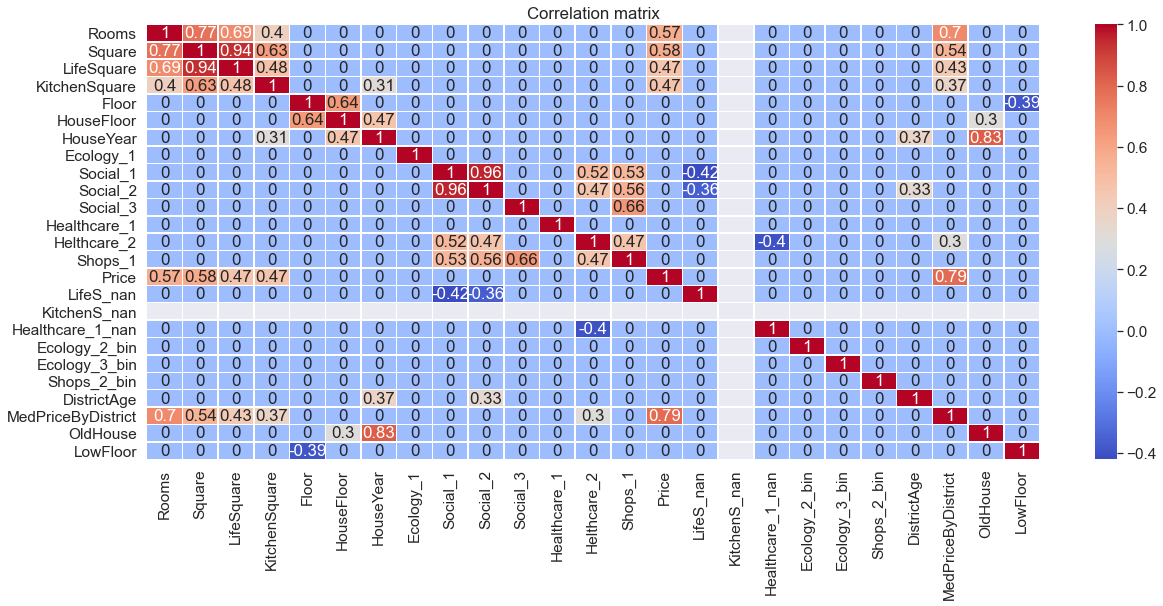

In [25]:
plt.figure(figsize = (20, 8))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Перенос данных на тестовую выборку

In [26]:
cor_type(test_df)
cor_data(test_df)
new_data(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,LifeS_nan,KitchenS_nan,Healthcare_1_nan,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,OldHouse,LowFloor
0,4567,44,1.0,36.847630,19.094182,5.000000,5,9.0,1970,0.036122,...,1,B,0,0,0,1,1,1,0,0
1,5925,62,1.0,42.493907,31.870430,10.000000,7,17.0,2017,0.072158,...,0,A,0,0,1,1,1,0,1,0
2,960,27,2.0,59.463678,44.597759,9.000000,19,19.0,1977,0.211401,...,1,B,1,0,1,1,1,1,0,0
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,...,0,B,0,0,1,1,1,1,0,1
4,746,74,1.0,53.837056,40.377792,5.383706,8,17.0,1977,0.309479,...,6,B,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.000000,6,8.0,1962,0.069660,...,2,B,0,0,1,1,1,1,0,0
4996,16138,38,3.0,93.698122,70.273592,10.000000,21,27.0,2018,0.060753,...,7,B,0,0,0,1,1,1,1,0
4997,3912,101,1.0,33.656723,19.003259,5.000000,2,5.0,1966,0.038693,...,5,B,0,0,0,1,1,1,0,1
4998,5722,10,1.0,38.635155,20.976257,9.000000,8,14.0,1970,0.089040,...,11,B,0,0,1,1,1,1,0,0


In [27]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')


In [28]:
test_df = test_df.merge(district_age, on=['DistrictId'], how='left')

In [29]:
test_df.loc[test_df['DistrictAge'].isnull(), 'DistrictAge'] = test_df['DistrictAge'].median()
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

Разбивка данных, построение модели

In [30]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
        'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'LifeS_nan',
       'KitchenS_nan', 'Healthcare_1_nan', 'Ecology_2_bin', 'Ecology_3_bin',
       'Shops_2_bin', 'DistrictAge', 'MedPriceByDistrict', 'OldHouse',
       'LowFloor']

target_name = ['Price']

In [31]:
X = train_df[feature_names]
y = train_df[target_name]

In [32]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=6
)

In [33]:
model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=6)

In [34]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=6)

In [35]:
y_pred_valid = model.predict(X_test_valid)

In [36]:
r2(y_test_valid, y_pred_valid)

0.7261768967852137

Отбор важных признаков

In [37]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,MedPriceByDistrict,0.808395
1,Square,0.069294
3,KitchenSquare,0.048165
10,Social_3,0.010264
9,Social_2,0.009874
5,HouseFloor,0.009648
20,DistrictAge,0.009156
2,LifeSquare,0.008552
8,Social_1,0.005482
11,Healthcare_1,0.005169


In [38]:
imp_feature_names = ['Rooms','Square','LifeSquare','KitchenSquare',
 'HouseFloor','HouseYear',
 'Social_1','Social_2','Social_3','Healthcare_1',
 'Helthcare_2','Shops_1',
 'DistrictAge','MedPriceByDistrict', 'LowFloor']

In [39]:
X = train_df[imp_feature_names]

In [40]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=6
)

In [41]:
model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=6)

In [42]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=6)

In [43]:
y_pred_valid = model.predict(X_test_valid)

In [44]:
r2(y_test_valid, y_pred_valid)

0.724919957172952

Градиентный бустинг

In [45]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=6,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
r2(y_train, y_train_preds)

0.911134943909296

In [46]:
y_pred_valid = gb_model.predict(X_test_valid)

In [47]:
r2(y_test_valid, y_pred_valid)

0.7566969348422099

Формирование предсказания

In [48]:
X_test_real = test_df[imp_feature_names]

In [49]:
test_df['Price'] = gb_model.predict(X_test_real)

In [50]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = test_df['Price']
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions1_.csv", index=False)